# Chapter 5    


## Introduction
Deep learning requires comprehensive knowledge of the building blocks of traditional machine learning.  That includes understanding the difference between supervised and unsupervised learning, which Hyperparameters to tune, and whether to use frequentist estimators or Bayesian inference.   

## 5.1 Learning Algorithms     
> “A computer
program is said to learn from experience E with respect to some class of tasks T
and performance measure P , if its performance at tasks in T , as measured by P ,
improves with experience E.”
> - Mitchell (1997)

### 5.1.1 The Task, $T$
Machine learning tasks are usually described in terms of how the machine learning system should process an __example__.  An example is a collection of **features** that have been quantitatively measure from some object or event.  An example is a typically a vector __x__ in $R^{n}$.  Using this vector, many problems can be solved by machine learning:
- Classification: given $x_{i}$, label y
- Classification with missing values: given a partial $x_{i}$, label y
- Regression: given $x_{i}$, output a continuous value of y
- Transcription: given $x_{i}$, write out a text version of y
- Machine Translation: take a $x_{i}$ (typically the origination language) and translate it into $y_{i}$ (the destination language)
- Structured Output: take a collection, say $x_{i}$ and map it back to a smaller group $y_{j}$.  Think mapping a collection of words back to noun, adjective, or verbs.  
- Anomaly Detection: think misuse of credit cards
- Synthesis and sampling: think GAN generation of images or medical claims data
- Imputation of Missing Values: given a set $x_{i}$ but with j entries missing, the algorithm must predict what those values are
- Denoising: an algorithm is provided a messy $x_{i}$ and it maps it back to a clean $x_{i}$.  
- Density Estimation (probability mass function estimation): the algorithm is askes to learn a function that takes a vector __x__ and maps it to a probability density function if continuous and a probability mass function if discrete.  

### 5.1.2 The Performance Measue, $P$    
For tasks like classification, classification with missing inputs, and transcription, we usually use __accuracy__ to determine a model's performance.  Accuracy is the proportion of examples for which the model produces the correct output.  Additionally, the **error rate**, 1 - Accuracy, is helpful in determining model performance.  For density estimation, these two won't suffice.  The performance metric best used here is determined by reporting the average log-probability the model assigns to examples.  

To account for the fact that models will be used in a production setting with data the model hasn't seen before, we split our data into training and test sets.  Then, we calculate the performance metric on that test split.  

### 5.1.3 The Experience, $E$

Machine learning algorithms can be broadly categorized as __unsupervised__ or **supervised** by what kind of experience they are allowed to have during the learning process.  Most tasks can and will experience the entire dataset when training.  On top of that, models from the realm of reinforcement learning will see data in addition to the whole dataset as they're meant to behave independently.  The factors to train on $x_{i}$ is called a __design matrix__.  Within supervised learning, the design matrix will be trained against a vector of labels, __y__.  

### 5.1.4 Linear Regression: an Example
Much, if not all, of the code listed below came from [here](https://colab.research.google.com/drive/1HL1HDCDhh1FiV-NckjfTYPd50K7H7wzi#scrollTo=uyKcSFJrbhRf&forceEdit=true&offline=true&sandboxMode=true).  Comments my own.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
import os


data = pd.read_csv('data/graduate-admissions/Admission_Predict_Ver1.1.csv')

In [2]:
data.columns = [col_name.strip() for col_name in data.columns.tolist()]

continuous_features = data[['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA']].values / 100
categorical_features = data[['Research']].values

In [3]:
X = np.concatenate([continuous_features, categorical_features], axis = 1)
y = data[['Chance of Admit']].values

train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.2)

In [4]:
X = tf.constant(train_features, dtype = tf.float32)
y = tf.constant(train_labels, dtype = tf.float32)

test_X = tf.constant(test_features, dtype = tf.float32)
test_y = tf.constant(test_labels, dtype = tf.float32)

In [5]:
# Custom performance functions
# 1) MSE function
# 2) The derivative of the mean squared error function
# 3) Hypothesis function / Regression function

def mean_squared_error( Y , y_pred ) -> tf.Tensor:
    """
    Args: 
        Y: list of y's from the data
        y_pred: y's predicted from model
    
    Returns:
        The reduced tensor
    """
    return tf.reduce_mean(tf.square(y_pred - Y ))

def mean_squared_error_deriv( Y , y_pred ) -> tf.Tensor:
    """
    Args:
        Y: list of y's from the data
        y_pred: y's predicted from model
    Return: 
        The reduced tensor
    """
    return tf.reshape( tf.reduce_mean( 2 * ( y_pred - Y ) ) , [ 1 , 1 ] )

def h(X, weights, bias) -> tf.Tensor:
    """ This is our hypothesis function.  It follows the form Y = WX + B which pertain
    to the arguments of this function.  
    Args: 
        X: a tensor of X values
        weights: a tensor of weights to multiply the tensor of X's by
        bias: a tensor to add on to our product
    Return:
        A tensor
    """
    return tf.tensordot( X , weights , axes=1 ) + bias

In [6]:
num_epochs = 10
num_samples = X.shape[0]
batch_size = 10
learning_rate = 0.001

# create the dataset from the original data
dataset = tf.data.Dataset.from_tensor_slices(( X , y))
dataset = dataset.shuffle( 500 ).repeat( num_epochs ).batch( batch_size )
iterator = dataset.__iter__()

num_features = X.shape[1]
# initialiaze some random normally distributed weights
weights = tf.random.normal( ( num_features , 1 ) ) 
bias = 0
# initialize lists of to display change
epochs_plot = list()
loss_plot = list()

for i in range( num_epochs ) :
    epoch_loss = list()
    # this will loop 40 times since 400 / 10
    for b in range( int(num_samples/batch_size) ):
        x_batch , y_batch = iterator.get_next()
        # get the predictions from the x-vals times weights plus the biases
        output = h( x_batch , weights , bias ) 
        # add the mean squared error from this iteration onto batch list
        loss = epoch_loss.append( mean_squared_error( y_batch , output ).numpy() )

        # start updating the weights and biases
        ## the first three will find the multiplier by the learning rate to update W
        dJ_dH = mean_squared_error_deriv( y_batch , output)
        dH_dW = x_batch
        dJ_dW = tf.reduce_mean( dJ_dH * dH_dW )
        # this identifies what to multiply the learning rate by to update B
        dJ_dB = tf.reduce_mean( dJ_dH )

        # updates your weights as the learning rate times your 
        weights -= ( learning_rate * dJ_dW )
        bias -= ( learning_rate * dJ_dB ) 

    # we are optimizing for mean squared error while 
    loss = np.array( epoch_loss ).mean()
    epochs_plot.append( i + 1 )
    loss_plot.append( loss ) 
    print( 'Loss is {}'.format( round(loss, 4) ) ) 

Loss is 5.531300067901611
Loss is 2.652400016784668
Loss is 1.2747000455856323
Loss is 0.6151000261306763
Loss is 0.3003000020980835
Loss is 0.1500999927520752
Loss is 0.07840000092983246
Loss is 0.04439999908208847
Loss is 0.0284000001847744
Loss is 0.020999999716877937


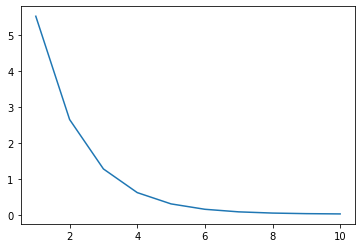

In [7]:
plt.plot( epochs_plot , loss_plot ) 
plt.show()

In [8]:
output = h( test_X , weights , bias ) 
labels = test_y

accuracy_op = tf.metrics.MeanAbsoluteError() 
accuracy_op.update_state(labels, output)
print( 'Mean Absolute Error = {}'.format(accuracy_op.result().numpy()))

Mean Absolute Error = 0.10455463081598282


# 5.2 Capacity, Overfitting, and Underfitting
The ability of a model to be trained and subsequently perform well on new inputs is called __generalization__.  To get a sense of expectation of the models performance initially, we can generate the **training error**.  However the creme de la creme of the modeling process revolves around the __test error__.  It is best practice to compare errors of multiple model builds on a __holdout set__.  

In general, the field of **statistical learning theory** will shed light onto best practices when trying tomake sure model generalizes well to unseen inputs.  When we split our data into __training__ and **test** sets, we make a couple of assumptions along the way called __i.i.d assumptions__:
1) the examples (rows) are **independent** of each other
2) the train and test set are __identically distributed__.  
Overall, these assumptions help us fit our data into what's called the **data generating distribution** which can be studied and quantified.  Additionally, the two biggest drivers in determining how well a model will generalize to new inputs is:
- How well the model minimizes the training error
- How small the gap can be made between the training and test error set
The factors that shed light onto how well the model is doing in the abover two areas are __overfitting__ and **underfitting**.  The ability of a model to fit many new, unseen inputs is called its __capacity__.  Machine learning models will generally perform best when their capacity matches the true complexity of the task.  

## 5.2.1 The "No Free Lunch Theorem"
Contrary to logic, machine learning hopes to find rules that are _probably_ good for _most_ of the members of the training set.  The **no free lunch theorem** states that, averaged over all possible data generating distributions, every classification algorithm has the same error rate when classifying unobserved points.  Thus, our goal as machine learning researchers should not be to find an optimal model for all scenarios.  Instead, our goal should be to understand which distributions make sense in real life to and fit models with those distributions to the real life scenario.  

## 5.2.2 Regularization
So far we have just described increasing or decreasing the capacity space of our algorithms when it comes to honing the models so that they generalize well.  Next up, is what is called __regularization__.  To quantify this scenario, let's create a variable measuring **weight decay**.  $J(w) = MSE_{train} + \lambda w^{T}w$.  Our goal is to minimize mean squared error with consideration for weights vector to have a smaller $L_{2}$ norm.  Our lambda here is a value chosen ahead of time that we will use as to whether we prefer smaller weights.  Underfit models would contain a $\lambda$ that is too large or excessive.  Overfit models would have a smaller $\lambda$.  The properly fit models that generalize well to unseen inputs would have a $\lambda$ in between this.  This process of quantifying the weight decay and optimizing for it is called __regularization__.  There are many regularizers we can add to a problem in order to help the models generalize better.  

# 5.3 Hyperparameters
Many models have settings within called **hyperparameters**.  To tune these settings, we create a __validation set__ from the training data.  Rule of thumb is to split off the test set and then to split the remaining data into 80% training and 20% validation.  

## 5.3.1 Cross Validation
When the test set is small, cross validation comes into play.  Cross validation, specfically _k-fold_ cross validation, splits the data into _i_ subsets where a model is trained on _i-1_ subsets and tested on the $i^{th}$ subset.  This is performed for all subsets throughout.  One problem with this is that there is no unbiased estimator for the average error from these subsets but no one seems to care.  

# 5.4 Estimators, Bias, and Variance
Using statistics to quantify parameter estimation, bias, and variance helps with notating concepts such as generalization, underfitting, and overfitting.  

## 5.4.1 Point Estimation
Point estimation is the attempt to find the single best prediction of some quantity of interest.  Point estimators are can be chosen as one likes but not all point estimators are created equal and some generalize better than others.  Point estimators are a function of the data values, and with the data values being chose at random, our point estimators are random variables.  From here we will discuss the most studied properties of these point estimators.  

## 5.4.2 Bias
The bias estimator is defined as:
$bias(\hat{\theta_{m}}) = E(\hat{\theta_{m}}) - \theta$
Thus, it's the difference between the expected value of our point estimator and the true value.  A point estimator $\hat{\theta_{m}}$ is said to be **unbiased** if $bias(\hat{\theta_{m}})$ = 0 which would imply $E(\hat{\theta_{m}}) = \theta$ based on our equation above. A point estimator $\hat{\theta_{m}}$ is said to be __asymptotically unbiased__ if $\lim_{m\to\infty}bias\hat{\theta_{m}} = 0$ whic implies $\lim_{m\to\infty}E(\hat{\theta_{m})} = \theta$

Cue up three to four examples of unbiased estimators being chosen (like in STA with Bagui).  

## 5.4.3 Variance and Standard Error
As we have looked at point estimation, there is also an effore we must undertake to look at how estimating this value will vary.  That __variance__ is denoted as $V(\hat\theta)$ with the square root of this being called the **standard error** labelled $SE(\hat\theta)$.  The $SE(\hat\theta) = \frac{\sigma}{\sqrt{m}}$.  Then, the 95% confidence interval centered on the mean $\hat\mu_{m}$ is $\hat\mu - 1.96SE(\hat\mu_{m}), \hat\mu_{m} + 1.96SE(\hat\mu_{m})$.  

## 5.4.4 Trading off Bias and Variance to Minimize Mean Squared Error
Bias measures the expected deviation from the true value of the function or parameter.  Variance measures the dispersion from the expected estimator value that any particular sampling of the data is likely to cause.  Would you rather have larger bias?  Or, larger variance?  Using MSE on the estimates wraps Bias and Variance into one equation.  __Consistency__ is the property that ensures that the bias induced by the estimator diminishes as the number of data examples grows.  

# 5.5 Maximum Likelihood Estimation
Assuming a parametric model of $m$ examples drawn independently from the true but unknown data generating distribution $p_{data}(x)$, we can expect the Maximum Likelihood Estimator (MLE) for $\theta$ is: $\theta_{ML} = arg max_{\theta}p_{model}(X; \theta) = arg max_{\theta}\prod_{i = 1}^{m}p_{model}(x^{i}; \theta$.  This process of finding the maximum likelihood estimate becomes known as minimizing or maximizing the Kullback-Leibler (KL) divergence.  KL divergence has a minimum value of zero.  

## 5.5.1 Conditional Log-likelihood and Mean Square Error
Within the context of supervised learning, our goal is to identify the $y$ value that is most likely given our list of x's.  Thus, $\theta_{ML} = arg max_{\theta} P(Y | X; \theta)$.  Or, if i.i.d., $\theta_{ML} = arg max_{\theta} \sum_{i=1}^{m}log P(y^{i} | x^(i); \theta)$.  

## 5.5.2 Properties of Maximum Likelihood 
The biggest driver behind the m.l.e. is that it can be shown to be the best estimator asymptotically as your number of training examples go to $\inf$.  As the number of training examples go to $\inf$, the m.l.e. is said to display _consistency_ defined above.  Thus, it converges to the true parameter value with more training data.  There are two stipulations:    
1) The true distribution $p_{data}$ must lie within the model family $p_{model}(.;\theta)$.  Otherwise, no estimator can recover $p_{data}$.      
2) The true distribution $p_{data}$ must correspond to exactly one value of $\theta$.  Otherwise, m.l.e. can recover the correct and appropriate $p_{data}$, but it cannot determine the value of $\theta$ was used by the data generating process.  

Though this estimator may display consistency, consistent estimators do vary in what is called **statistical efficiency**.  This efficiency is determined as the generalization error given a set number of training variables, _m_.  This efficiency is studied in the parametric case and the Cramer Rao lower bound determines the MLE to have the lowest mean squared error of any estimator.  

# 5.6 Bayesian Statistics
All of these previous sections have dealt with **frequentist statistics** and approached centered on a single value of $\theta$.  Outside of a single value of $\theta$, there's a brand new world that considers the domain of _all_ $\theta$.  This realm that considers all possible values of $\theta$ is called __Bayesian Statistics__.  

Quick Review of the Two Philosophies:
- Frequentist pov: the true parameter $\theta$ is unknown but fixed.  
- Bayesian pov: the point estimate $\hat{\theta}$ is a random variable on account of it being from a function of the dataset.  

As a difference, Bayesians use probability to reflect degrees of certainty of states of knowledge.  They don't see the dataset as random.  Instead, the true parameter $\theta$ is unknown or uncertain and thus is as random variable.  

Bayesians start their data modeling process with considering a knowledge of the true parameter $\theta$ with highest validity by looking at the **prior distribution**, $p(\theta)$.  (They refer to this as the __prior__)  With this start, the practicioner selects a prior distribution that is __very__ broad and has high entropy.  This prior will accomodate the uncertainty around $\theta$ before they see any data.  

As an example, a statistician selects that $\theta$ comes from a uniform distribution.  After this, data is brought in of size _m_.  This statistician can then find the impact that the data has had on their prior belief that $\theta$ comes from a uniform distribution by finding $p(\theta|x^{(1)}...x^{(m)}) = \frac{p(x^(1),....,x^(m)|\theta)p(\theta)}{p(x^({1)},...,x^{(m)}})$.  

As opposed to Frequentists who use Maximum Likelihood Estimators using a point estimate of $\theta$, the Bayesian approach is to make predictions using a full distribution over $\theta$.  In practice, the predicted distribution over the next data sample, $x^{(m+1)}$ is the integral of the probability of $x^{(m+1)}$ given $\theta$ times the probability of $\theta$ given $x^{(1)},...,x^{(m)}$.  Or, in equation form: $p(x^{(m+1)}|x^{(1)},...,x^{(m)}) = \int p(x^{(m+1)} |\theta)p(\theta|x^{(1)},...,x^{(m)})d\theta$

There are a couple of differences when it comes to the mle between the schools of thought:    
1) The frequentist approaches uncertainty by calculating and displaying the variance of the point estimate.  A Bayesian, on the other hand, will simply integrate over the area of uncertainty.      
2) The frequentist would call out the naming of a prior distribution as a subjctive argument which can be fallible.  In fact the prior distribution does shift the probability mass function in the direction of the parameter space decided upon _a priori_.  

Bayesian methods seem to shine with a few pieces of training data but their cost seems to outweigh there worth as they fall prey at scale.  

## 5.6.0 An Example: Bayesian Linear Regression    
Take an example of linearly related data and fit a Bayesian Linear Model to it. 
Most of the code comes from [here](https://www.quantstart.com/articles/Bayesian-Linear-Regression-Models-with-PyMC3) and was used as an example for how to fit a Bayesian linear model. The code was adapted to use the `pymc3`

Text(0.5, 1.0, 'Linear Fit of 1000 tandom data points')

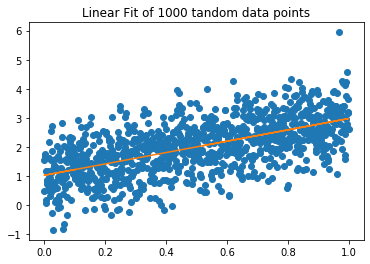

In [9]:
def simulate_linear_data(N, beta_0, beta_1, eps_sigma_sq):
    """
    Simulate a random dataset using a noisy linear process.  
    N: number of data points to simulate
    beta_0: Intercept
    beta_1: Slope of univariate predictor, X
    eps_sigma_sq: variance
    """
    # Create a pandas DataFrame with column 'x' containing
    # N uniformly sampled values between 0.0 and 1.0.
    df = pd.DataFrame(
        {"x": 
            np.random.RandomState(42).choice(np.arange(N)/1000.0, 1000, replace=False
            )
        }
    )
    # Use a linear model (y ~ beta_0 + beta_1*x + epsilon) to 
    # generate a column 'y' of responses based on 'x'
    eps_mean = 0.0
    df["y"] = beta_0 + beta_1 * df["x"] + np.random.RandomState(8675309).normal(eps_mean, eps_sigma_sq, N)
    return df

# Set True parameters
beta_0 = 1.0 # Intercept
beta_1 = 2.0 # Slope

# Simulate 1000 data points to look at with a variance of 0.75
N = 1000
eps_sigma_sq = 0.75

# Simulate the "linear" data using the above parameters
df = simulate_linear_data(N, beta_0, beta_1, eps_sigma_sq)
df["y_hat"] = linregress(df["x"], df["y"])[0] * df["x"] + linregress(df["x"], df["y"])[1]
plt.plot(df["x"], df["y"], 'o', df["x"], df["y_hat"])
plt.title('Linear Fit of 1000 tandom data points')

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x, Intercept]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:45<00:00, 487.72draws/s]
The acceptance probability does not match the target. It is 0.9007081934380636, but should be close to 0.8. Try to increase the number of tuning steps.


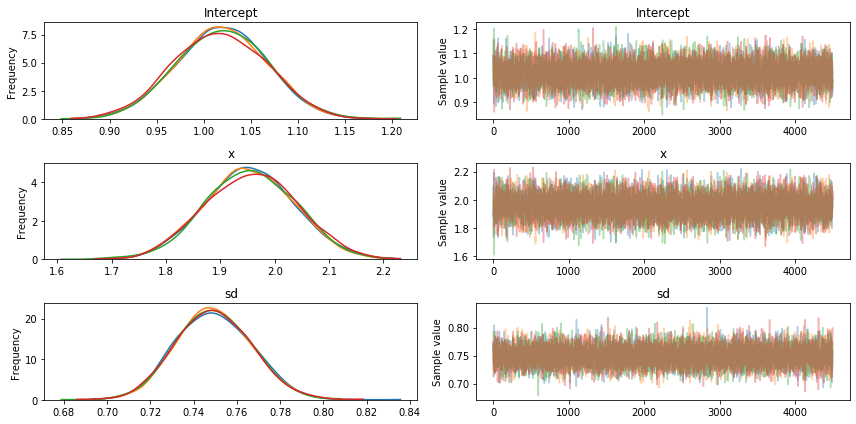

In [10]:
# now that we have 1000 data points we're going to try to fit a
# Bayesian model to the data

def glm_mcmc_inference(df, iterations = 5000):
    """
    Calculates the Markov Chain Monte Carlo trace of a 
    Generalized Linear Model Bayesian linear regression model
    on supplied data.  
    
    df: DataFrame containing the data
    iterations: Number of iterations to carry out MCMC
    """
    # Using PyMC3 to make the model context
    basic_model = pm.Model()
    with basic_model:
        # Create the glm using the Patsy model syntax
        # Let's use a Normal distribution for the likelihood 
        pm.glm.GLM.from_formula("y ~ x", df)
                
        # Use the No-U-Turn Sampler
        step = pm.NUTS()
        
        # Calculate the trace
        trace = pm.sample(iterations, 
                          step = step,
                         random_seed = 8675309,
                         progress_bar = True)
    return trace

trace = glm_mcmc_inference(df)
pm.traceplot(trace[500:])
plt.show()

We can see in the above distributions that the intercept centers toward 1.0, the slope leans a bit left of 2.0, and the variance sits at 0.75.  

## 5.6.1 Maximum _A Posteriori_ (MAP) Estimation
In principle, using the full Bayesian posterior distribution over the parameter $\theta$, it is still often desirable to get a single point estimate.  For that, we turn to the MAP or Maximum _A Posteriori_.  The reason we turn to one value of these values is for tractability and approximating.  The MAP of $\theta$ can be seen as follows:

$\theta_{MAP} = \underset{\theta}{\operatorname{argmax}} \;\;\;\; p(\theta | x) = \underset{\theta}{\operatorname{argmax}}  \;\;\;\;log p(x|\theta) + log p(\theta)$

where $log \;p(x|\theta)$ is the standard log-likelihood term and $log \;p(\theta)$ is the prior distribution.  

As with full Bayesian inference, MAP Bayesian Inference draws from the knowledge in the prior not in the training data.  This extra information helps reduce variance in the MAP Point Estimate but it does so at the trade-off of increased bias.  

# 5.7 Supervised Learning Algorithms
Supervised learning algorithms fit training data (__x__) to training labels (y) created by human "supervisors".  

## 5.7.1 Probabilistic Supervised Learning
Most algorithms in this book are set by estimating a probability distribution of $p(y | x_{i})$.  This can be done for a parameter vector $\theta$  using maximum likelihood estimation for a parametric family of distributions $p(y|x; \theta$.  Take Linear Regression as an example: 
$p(y|x;\theta) = N(y; \theta^{T}x, I).$  We can squish this scenario down to predicting two classes: 1 or 0.  Since the probability of both classes need to add up to 1, we need only specify the probability of class 1.  With the normal distribution being parameterized in terms of its mean, any value supplied is valid.  However, if we're looking only at the probabilities between 0 and 1, this limits our options.  So, how do we move from all potential values to those between 0 and 1?  The logistic sigmoid function.  This function will squash all real values between 0 and 1.    

## 5.7.2 Support Vector Machines
This model can be written in the form $w^{T}x + b$, where $w$ is a weight vector, $x$ is a data vector, and $b$ is a constant.  Instead of making probabilities as it's prediction, the SVM makes positive or negative predictions corresponding to the desired classes.  

## 5.7.3 Other Simple Supervised Learning Algorithms
There is a non-probabilistic supervised learning algorithm called k-nearest neighbors.  This model is non-parametric so it doesn't have any parameters to deal with.  In fact there's no real training that goes on in the modeling process.  At the time of start, if we have _x_ test data points, we find _k_ nearest neighbors to those x's and the average of the y values of the k are returned as the responses for each x.  The important things to glean from k-nearest neighbor is that it can be quite accurate with a large dataset and can severely overfit given a small dataset.    

Another learning algorithm that has a great run since around 1984 is the decision tree.  A decision tree breaks at optimal splits where the response variable is the _most_ heterogenous along the split.  All in all, k-nearest neighbor and decision trees have powerful qualities and some inherent weaknesses.  Those qualities and weaknesses can be leveraged to make a more performant models ahead.  

# 5.8 Unsupervised Learning

### 5.8.1 Principal Component Analysis

### 5.8.2 k-means

# 5.9 Stochastic Gradient Descent
Nearly all of deep learning is powered by this algorithm.  In order for a model to generalize well, it must be trained on many training examples.  However, when trained on large amounts of data the cost function gets prohibitively more expensive to leverage.  All in all, these cost functions require computing gradients at the order of O(m).  With billions of rows, this will be much too long.  

With stochastic gradient descent, our gradient is an _expectation_.  And this expectation can be estimated from using a small batch of training data. Specifically, we'll call this a __mini-batch__.  A minibatch is a sample drawn uniformly from the training data set.  Its range of sample size generally fall between 1 and a couple hunderd.  The estimate of the gradient can be written as:    
$g = \frac{1}{m'}\nabla_{\sigma}\sum^{m'}_{i = 1}L(x^{i}, y^{i}, \theta)$   From this point, $\theta - \epsilon(g) \to \theta$ where $\epsilon$ is the learning rate.    

Outside of deep learning, the kernel trick explained in SVM's were used.  With that requiring the use of $MxM$ matrices, training on a billion rows would become unruly.  Thus, stochastic gradient descent is used because it scales better and finds minima at regular clip.  

# 5.10 Building a Machine Learning Model

# 5.11 Challenges Motivating Deep Learning

## 5.11.1 The Curse of Dimensionality
Machine learning problems become difficult when the number of columns or regressors becomes large.  

## 5.11.2 Local Constancy and Smoothness Regularization
Machine learning problems set a prior that a function is generally smooth over the area it attempts to generalize from.  

> For example, imagine that the target function is a kind of checkerboard. A
checkerboard contains many variations but there is a simple structure to them.
Imagine what happens when the number of training examples is substantially
smaller than the number of black and white squares on the checkerboard. Based
on only local generalization and the smoothness or local constancy prior, we would
be guaranteed to correctly guess the color of a new point if it lies within the same
checkerboard square as a training example. There is no guarantee that the learner
could correctly extend the checkerboard pattern to points lying in squares that do
not contain training examples. With this prior alone, the only information that an
example tells us is the color of its square, and the only way to get the colors of the
entire checkerboard right is to cover each of its cells with at least one example.

## 5.11.3 Manifold Learning
A __manifold__ is a connected region.  










